# Solving convection-coupled melting with adaptive mixed finite elements

This Jupyter notebook shows how to solve the convection-coupled melting benchmark with the general approach of [5], using mixed finite elements in FEniCS with goal-oriented adaptive mesh refinement (AMR) as presented in [6].

|Nomenclature||
|------------|-|
|$\mathbf{x}$| point in the spatial domain|
|$t$| time |
|$p = p(\mathbf{x},t)$| pressure field |
|$\mathbf{u} = \mathbf{u}(\mathbf{x},t)$| velocity vector field |
|$T = T(\mathbf{x},t)$| temperature field |
|$\phi$ | solid volume fraction |
|$()_t = \frac{\partial}{\partial t}$| time derivative |
|$T_r$| central temperature of the regularization |
|$r$| smoothing parameter of the regularization |
|$\mu$| constant dynamic viscosity of the fluid|
|$\mathbf{f}_B(T)$| temperature-dependent buoyancy force|
|$\mathrm{Pr}$ | Prandtl number|
|$\mathrm{Ra}$ | Rayleigh number|
|$\mathrm{Ste}$| Stefan number|
|$\Omega$| spatial domain |
|$\mathbf{w} = \begin{pmatrix} p \\ \mathbf{u} \\ T \end{pmatrix}$| system solution|
|$\mathbf{W}$| mixed finite element function space |
|$\boldsymbol{\psi} = \begin{pmatrix} \psi_p \\ \boldsymbol{\psi}_u \\ \psi_T \end{pmatrix} $| mixed finite element basis functions|
|$\gamma$| penalty method stabilization parameter|
|$T_h$| hot boundary temperature |
|$T_c$| cold boundary temperature |
|$\Delta t$| time step size |
|$\Omega_h$| discrete spatial domain, i.e. the mesh |
|$M$| goal functional |
|$\epsilon_M$| error tolerance for goal-oriented AMR |

## Governing equations

To model convection-coupled melting, we employ the system composed of the unsteady incompressible Navier-Stokes-Boussinesq equations and a enthalpy convection-diffusion equation, scaled for unit Reynolds Number as explained in [5], as

\begin{align*} 
    \nabla \cdot \mathbf{u} &= 0  \\
    \mathbf{u}_t + \left( \mathbf{u}\cdot\nabla \right)\mathbf{u} + \nabla p - 2\nabla \cdot \left(\mu(\phi)\mathbf{D}(\mathbf{u})\right) + \mathbf{f}_B(T) &= 0  \\
    T_t + \mathbf{u}\cdot\nabla T - \frac{1}{\mathrm{Pr}}\Delta T - \frac{1}{\mathrm{Ste}}\phi_t &= 0
\end{align*}

where  $\mathbf{D}(\mathbf{u}) = \mathrm{sym}(\mathbf{u}) = \frac{1}{2}\left(\nabla \mathbf{u} +  \left( \nabla \mathbf{u} \right)^{\mathrm{T}} \right)$ is the Newtonian fluid's rate of strain tensor and the regularized semi-phase-field (representing the solid volume fraction) is 

\begin{align*}
    \phi(T) = \frac{1}{2}\left(1 + \tanh{\frac{T_r - T}{r}} \right)
\end{align*}

## Python packages

Import the Python packages for use in this notebook.

We use the finite element method library FEniCS.

In [1]:
import fenics

|Note|
|----|
| This Jupyter notebook server is using FEniCS 2017.2.0 from ppa:fenics-packages/fenics, installed via `apt` on Ubuntu 16.04.|

FEniCS has convenient plotting features that don't require us to import `matplotlib`; but using `matplotlib` directly will allow us to annotate the plots.

In [2]:
import matplotlib

Tell this notebook to embed graphical outputs from `matplotlib`, includings those made by `fenics.plot`.

In [3]:
%matplotlib inline

## Initial mesh

Define a coarse mesh on the unit square and refine it near the hot wall where there will be an initial layer of melt.

In [4]:
N = 1

mesh = fenics.UnitSquareMesh(N, N)


class HotWall(fenics.SubDomain):
    
    def inside(self, x, on_boundary):

        return on_boundary and fenics.near(x[0], 0.)


hot_wall = HotWall()


initial_hot_wall_refinement_cycles = 6

for cycle in range(initial_hot_wall_refinement_cycles):

    edge_markers = fenics.MeshFunction("bool", mesh, 1, False)

    hot_wall.mark(edge_markers, True)

    fenics.adapt(mesh, edge_markers)

    mesh = mesh.child()

Let's look at the mesh.

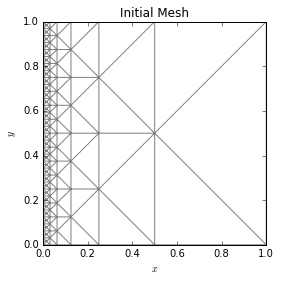

In [5]:
fenics.plot(mesh)

matplotlib.pyplot.title("Initial Mesh")

matplotlib.pyplot.xlabel("$x$")

matplotlib.pyplot.ylabel("$y$")

## Mixed finite element function space, test functions, and solution functions

Make the mixed finite element. We choose pressure and velocity subspaces analagous to the Taylor-Hood (i.e. P2P1) mixed element, but we extend this further with a P1 element for the temperature.

In [6]:
P1 = fenics.FiniteElement('P', mesh.ufl_cell(), 1)

P2 = fenics.VectorElement('P', mesh.ufl_cell(), 2)

mixed_element = fenics.MixedElement([P1, P2, P1])

|Note|
|----|
|`fenics.FiniteElement` requires the `mesh.ufl_cell()` argument to determine some aspects of the domain (e.g. that the spatial domain is two-dimensional).|

Make the mixed finite element function space $\mathbf{W}$, which enumerates the mixed element basis functions on each cell of the mesh.

In [7]:
W = fenics.FunctionSpace(mesh, mixed_element)

Make the test functions $\psi_p$, $\boldsymbol{\psi}_u$, and $\psi_T$.

In [8]:
psi_p, psi_u, psi_T = fenics.TestFunctions(W)

Make the system solution function $\mathbf{w} \in \mathbf{W}$ and obtain references to its components $p$, $\mathbf{u}$, and $T$.

In [9]:
w = fenics.Function(W)

p, u, T = fenics.split(w)

### Benchmark parameters

Set constant Prandtl, Rayleigh, and Stefan numbers for the convection-coupled melting benchmark in [5] and [6]. For each we define a `fenics.Constant` for use in the variational form so that FEniCS can more efficiently compile the finite element code.

In [10]:
prandtl_number = 56.2

Pr = fenics.Constant(prandtl_number)

rayleigh_number = 3.27e5

Ra = fenics.Constant(rayleigh_number)

stefan_number = 0.045

Ste = fenics.Constant(stefan_number)

Define the idealized linear Boussinesq buoyancy, scaled according to [5],

\begin{align*}
\mathbf{f}_B(T) = \frac{\mathrm{Ra}}{\mathrm{Pr}} T\begin{pmatrix} 0 \\ -1 \end{pmatrix}.
\end{align*}

In [11]:
f_B = Ra/Pr*T*fenics.Constant((0., -1.))

Set the regularized semi-phase-field with a central temperature $T_r$ and smoothing parameter $r$.

In [12]:
regularization_central_temperature = 0.01

T_r = fenics.Constant(regularization_central_temperature)

regularization_smoothing_parameter = 0.025

r = fenics.Constant(regularization_smoothing_parameter)

tanh = fenics.tanh

def phi(T):
    
    return 0.5*(1. + tanh((T_r - T)/r))

Set the phase-dependent dynamic viscosity

In [13]:
liquid_dynamic_viscosity = 1.

mu_L = fenics.Constant(liquid_dynamic_viscosity)

solid_dynamic_viscosity = 1.e8

mu_S = fenics.Constant(solid_dynamic_viscosity)

def mu(phi):
    
     return mu_L + (mu_S - mu_L)*phi

Furthermore the benchmark problem involves hot and cold walls with constant temperatures $T_h$ and $T_c$, respectively.

In [14]:
hot_wall_temperature = 1.

T_h = fenics.Constant(hot_wall_temperature)

cold_wall_temperature = -0.01

T_c = fenics.Constant(cold_wall_temperature)

### Time discretization

To solve the initial value problem, we will prescribe the initial values, and then take discrete steps forward in time which solve the governing equations.

We set the initial values such that a small layer of melt already exists touching the hot wall.

\begin{align*}
    p^0  &= 0  \\
    \mathbf{u}^0 &= \mathbf{0} \\
    T^0  &= 
    \begin{cases}
        T_h, && x_0 < x_{m,0} \\
        T_c, && \mathrm{otherwise}
    \end{cases}
\end{align*}

Interpolate these values to create the initial solution function.

In [15]:
initial_melt_thickness = 1./2.**(initial_hot_wall_refinement_cycles - 1)

w_n = fenics.interpolate(
    fenics.Expression(("0.", "0.", "0.", "(T_h - T_c)*(x[0] < x_m0) + T_c"),
                      T_h = hot_wall_temperature, T_c = cold_wall_temperature,
                      x_m0 = initial_melt_thickness,
                      element = mixed_element),
    W)

p_n, u_n, T_n = fenics.split(w_n)

--- Instant: compiling ---


Let's look at the initial values now.

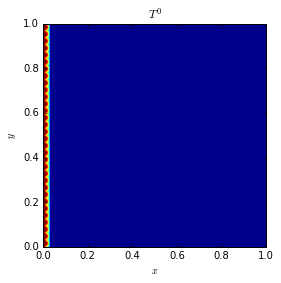

In [16]:
fenics.plot(T_n)

matplotlib.pyplot.title("$T^0$")

matplotlib.pyplot.xlabel("$x$")

matplotlib.pyplot.ylabel("$y$")

For the time derivative terms $\mathbf{u}_t$, $T_t$, and $\phi_t$, we apply the first-order implicit Euler finite difference time discretization, i.e.

\begin{align*}
    \mathbf{u}_t = \frac{\mathbf{u}^{n+1} - \mathbf{u}^n}{\Delta t} \\
    T_t = \frac{T^{n+1} - T^n}{\Delta t} \\
    \phi_t = \frac{\phi^{n+1} - \phi^n}{\Delta t} 
\end{align*}

|Note|
|----|
|For our implementation, we will use the shorthand $\mathbf{w} = \mathbf{w}^{n+1}$|

Choose a time step size and set the time derivative terms.

In [17]:
timestep_size = 10.

Delta_t = fenics.Constant(timestep_size)

u_t = (u - u_n)/Delta_t

T_t = (T - T_n)/Delta_t

phi_t = (phi(T) - phi(T_n))/Delta_t

## Nonlinear variational form

We can write the nonlinear system of equations as

\begin{align*}
\mathbf{F}(\mathbf{w}) = \mathbf{0}
\end{align*}

To obtain the finite element weak form, we follow the standard Ritz-Galerkin method extended for mixed finite elements [1]. Therefore, we multiply the system  *from the left* by test functions $\boldsymbol{\psi}$ from the mixed finite element function space $\mathbf{W}$ and integrate over the spatial domain $\Omega$. This gives us the variational problem: Find $\mathbf{w} \in \mathbf{W}$ such that

\begin{align*}
    \mathcal{F}(\boldsymbol{\psi};\mathbf{w}) = \int_\Omega 
    \boldsymbol{\psi}^\mathrm{T} \mathbf{F}(\mathbf{w}) 
    d\mathbf{x} = 0 \quad \forall \boldsymbol{\psi} \in \mathbf{W}
\end{align*}

Integrating $\mathcal{F}$ by parts yields
 
\begin{align*}
    \mathcal{F}(\boldsymbol{\psi};\mathbf{w}) = -(\psi_p,\nabla\cdot\mathbf{u}) \\
    + (\boldsymbol{\psi}_u, \mathbf{u}_t + \nabla\mathbf{u}\cdot\mathbf{u} + \mathbf{f}_B(T)) -(\nabla\cdot\boldsymbol{\psi}_u,p) + 2\mu(\mathbf{D}(\boldsymbol{\psi}_u),\mathbf{D}(\mathbf{u})) \\
    + (\psi_T,T_t - \frac{1}{Ste}\phi_t) + (\nabla \psi_T, \frac{1}{\mathrm{Pr}}\nabla T - T\mathbf{u})
\end{align*}

|Note| 
|----|
|We denote integrating inner products over the domain as $(v,u) = \int_\Omega v u d \mathbf{x}$ or $(\mathbf{v},\mathbf{u}) = \int_\Omega \mathbf{v} \cdot \mathbf{u} d \mathbf{x}$.|

By default FEniCS will numerically integrate with an exact quadrature rule. For this particular problem, this yields a large enough number of quadrature points that FEniCS throws a warning. Let's choose a lower degree quadrature, which will greatly speed up the finite element matrix assembly.

In [18]:
dx = fenics.dx(metadata={'quadrature_degree': 8})

Define the nonlinear variational form $\mathcal{F}$.

In [19]:
inner, dot, grad, div, sym = \
    fenics.inner, fenics.dot, fenics.grad, fenics.div, fenics.sym
    
mass = -psi_p*div(u)

momentum = dot(psi_u, u_t + dot(grad(u), u) + f_B) - div(psi_u)*p \
    + 2.*mu(phi(T))*inner(sym(grad(psi_u)), sym(grad(u)))

enthalpy = psi_T*(T_t - 1./Ste*phi_t) + dot(grad(psi_T), 1./Pr*grad(T) - T*u)
        
F = (mass + momentum + enthalpy)*dx

We add a penalty method stabilization term $-\gamma(\psi_p,p)$, setting the stabilization parameter $\gamma = 10^{-7}$ as done in [5].

|Note|
|----|
|One can solve the incompressible Navier-Stokes equation **either** with P2P1 elements, **or** with the penalty method and P1P1 elements. Neither of these approaches works alone when also coupling the temperature convection-diffusion equation with Boussinesq buoyancy; but applying both stabilization methods together does work.|

In [20]:
penalty_stabilization_parameter = 1.e-7

gamma = fenics.Constant(penalty_stabilization_parameter)

F += -psi_p*gamma*p*dx

## Linearization
Notice that $\mathcal{F}$ is a *nonlinear* variational form. FEniCS will solve the nonlinear problem using Newton's method. This requires computing the Jacobian (formally the Gâteaux derivative) of the nonlinear variational form, yielding a a sequence of linearized problems whose solutions may converge to approximate the nonlinear solution.

We could manually define the Jacobian; but thankfully FEniCS can do this for us.

|Note|
|----|
|When solving linear variational problems in FEniCS, one defines the linear variational form using `fenics.TrialFunction` instead of `fenics.Function` (while both approaches will need `fenics.TestFunction`). When solving nonlinear variational problems with FEniCS, we only need `fenics.TrialFunction` to define the linearized problem, since it is the linearized problem which will be assembled into a linear system and solved.|

In [21]:
JF = fenics.derivative(F, w, fenics.TrialFunction(W))

## Boundary conditions

We need boundary conditions before we can define a nonlinear variational *problem* (i.e. in this case a boundary value problem).

We physically consider *no slip* velocity boundary conditions for all boundaries. These manifest as homogeneous Dirichlet boundary conditions. For the temperature boundary conditions, we consider a constant hot temperature on the left wall, a constant cold temperature on the right wall, and adiabatic (i.e. zero heat transfer) conditions on the top and bottom walls. Because the problem's geometry is simple, we can identify the boundaries with the following piece-wise function.

\begin{align*}
    T(\mathbf{x}) &= 
    \begin{cases}
        T_h , && x_0 = 0 \\
        T_c , && x_0 = 1 
    \end{cases}
\end{align*}

In [22]:
hot_wall = "near(x[0],  0.)"

cold_wall = "near(x[0],  1.)"

adiabatic_walls = "near(x[1],  0.) | near(x[1],  1.)"

walls = hot_wall + " | " + cold_wall + " | " + adiabatic_walls

Define the boundary conditions on the appropriate subspaces.

In [23]:
W_u = W.sub(1)

W_T = W.sub(2)

boundary_conditions = [
    fenics.DirichletBC(W_u, (0., 0.), walls),
    fenics.DirichletBC(W_T, hot_wall_temperature, hot_wall),
    fenics.DirichletBC(W_T, cold_wall_temperature, cold_wall)]

## Nonlinear variational problem

Now we have everything we need to define the variational problem.

In [24]:
problem = fenics.NonlinearVariationalProblem(F, w, boundary_conditions, JF)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


## Goal-oriented adaptive mesh refinement (AMR)

We wish to solve the problem with adaptive mesh refinement (AMR). For this it helps to explain that we have already defined the *discrete* nonlinear variational problem using FEniCS: Find $\mathbf{w}_h \in \mathbf{W}_h \subset \mathbf{W}(\Omega)$ such that

\begin{align*}
    \mathcal{F}(\boldsymbol{\psi}_h;\mathbf{w}_h) = 0 \quad \forall \boldsymbol{\psi}_h \in \mathbf{W}_h \subset \mathbf{W}
\end{align*}

Given this, goal-oriented AMR poses the problem: Find $\mathbf{W}_h \subset \mathbf{W}(\Omega)$ and $\mathbf{w}_h \in \mathbf{W}_h$ such that

\begin{align*}
    \left| M(\mathbf{w}) - M(\mathbf{w}_h) \right| < \epsilon_M
\end{align*}

where $M$ is some goal functional of the solution which we integrate over the domain, and where $\epsilon_M$ is a prescribed tolerance. Note that since we do not know the exact solution $\mathbf{w}$, this method requires an error estimator. This is detailed in [2]. For our purposes, we only need to define $M$ and $\epsilon_M$.

We choose a goal analagous to the melting rate.

\begin{align*}
    M = \int_\Omega \phi_t \hspace{1mm} d\mathbf{x}
\end{align*}

In [25]:
M = phi_t*dx

Let's set the tolerance somewhat arbitrarily. For real problems of scientific or engineering interest, one might have accuracy requirements which could help drive this decision.

In [26]:
epsilon_M = 4.e-5

## The benchmark solution

Finally we instantiate the adaptive solver with our problem and goal

In [27]:
solver = fenics.AdaptiveNonlinearVariationalSolver(problem, M)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


set the Newton solver's initial guess based on the initial values

In [28]:
w.leaf_node().vector()[:] = w_n.leaf_node().vector()

and solve the problem to the prescribed tolerance.

In [29]:
solver.solve(epsilon_M)

|Note|
|----|
|`solver.solve` will modify the solution `w`, which means that `u` and `p` will also be modified.|

Now plot the solid volume fraction, velocity field, and adapted mesh.

Calling FFC just-in-time (JIT) compiler, this may take some time.


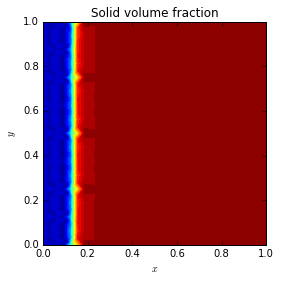

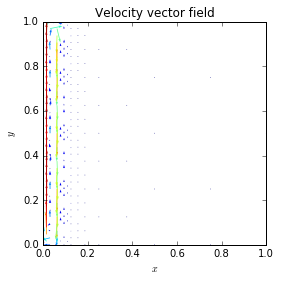

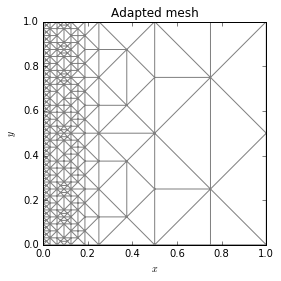

In [30]:
def plot(w):
    
    p, u, T = fenics.split(w.leaf_node())
    
    
    fenics.plot(phi(T))

    matplotlib.pyplot.title("Solid volume fraction")

    matplotlib.pyplot.xlabel("$x$")

    matplotlib.pyplot.ylabel("$y$")
    
    matplotlib.pyplot.show()
    
    
    fenics.plot(u)

    matplotlib.pyplot.title("Velocity vector field")

    matplotlib.pyplot.xlabel("$x$")

    matplotlib.pyplot.ylabel("$y$")
    
    matplotlib.pyplot.show()

    
    fenics.plot(mesh.leaf_node())

    matplotlib.pyplot.title("Adapted mesh")

    matplotlib.pyplot.xlabel("$x$")

    matplotlib.pyplot.ylabel("$y$")
    
    matplotlib.pyplot.show()
    
    
plot(w)

Let's run a few more time steps.

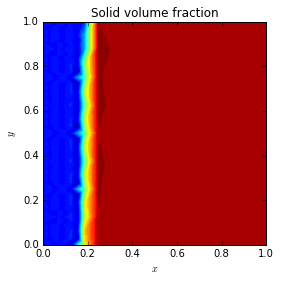

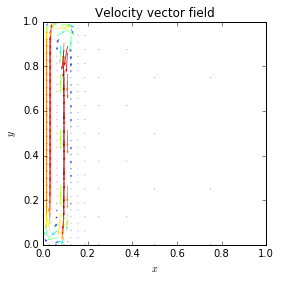

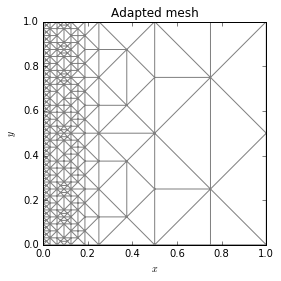

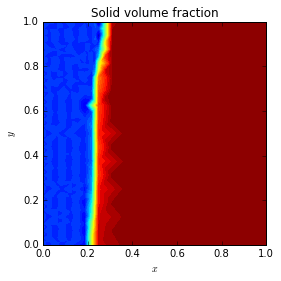

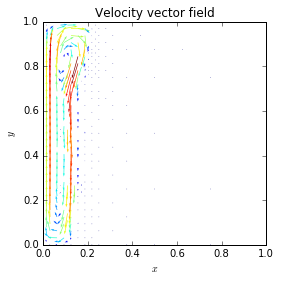

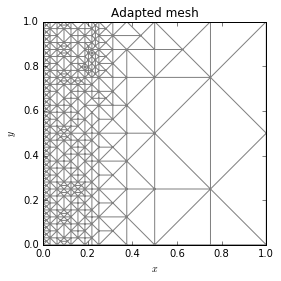

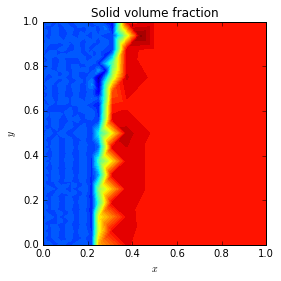

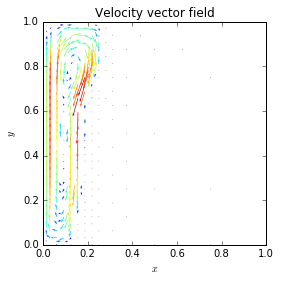

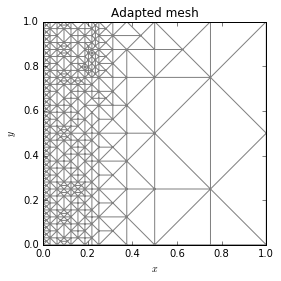

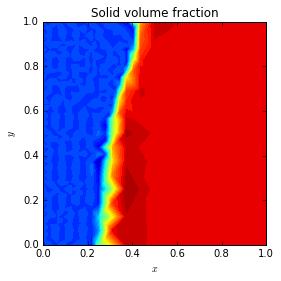

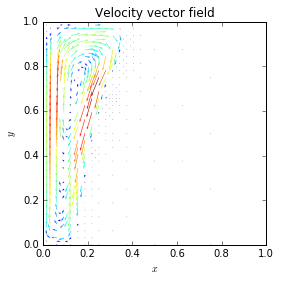

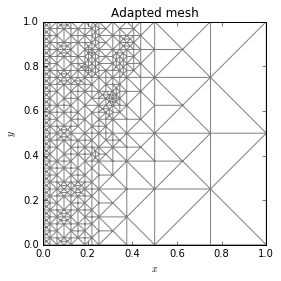

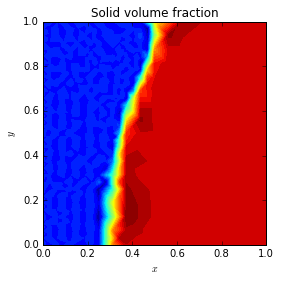

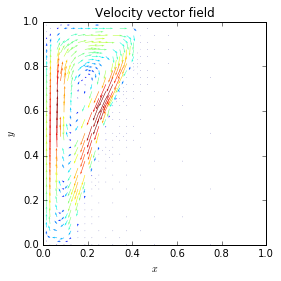

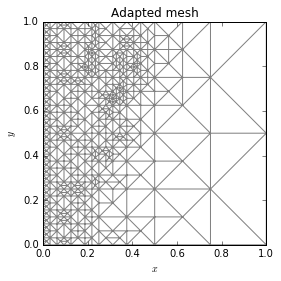

In [31]:
for timestep in range(5):
    
    w_n.leaf_node().vector()[:] = w.leaf_node().vector()
    
    solver.solve(epsilon_M)
    
    plot(w)

## References
[1] F Brezzi and M Fortin. **Mixed and hybrid finite element methods**, volume 15. *Springer Science & Business Media*, 1991.

[2] W Bangerth and R Rannacher. **Adaptive Finite Element Methods for Differential Equations**. *Springer Science & Business Media*, 2003.

[3] J Donea and A Huerta. **Finite element methods for flow problems.** *John Wiley & Sons*, 2003. 

[4] A Logg, KA Mardal, and GN Wells. **Automated Solution of Differential Equations by the Finite Element Method**, *Springer*, 2012.

[5] I Danaila, R Moglan, F Hecht, and S Le Masson. **A newton method with adaptive finite elements for solving phase-change problems with natural convection.** *Journal of Computational Physics*, 274:826–840, 2014.

[6] AG Zimmerman and J Kowalski. **Monolithic simulation of convection-coupled phase-change - verification and reproducibility.** *arXiv:1801.03429 [physics.flu-dyn]*, 2018.